#**Maestría en Inteligencia Artificial Aplicada**

##**Curso: Operaciones de Aprendizaje Automático MLOps**

###Tecnológico de Monterrey

###Prof Gerardo Rodriguez Hernández

## **Fase 1 Avance del proyecto**

Nombre y matrícula:
- Manuel Antonio Acevedo Ham A01410910
- Jorge Daniel Amezola Gutiérrez
- Ana Clemencia Aristizábal L A01795433
- Alan Samuel Arriaga Castillo
- Kevin Balderas Sánchez A01795149

##SETUP

In [1]:
#!pip install git+https://github.com/<usuario>/<repo>.git


In [4]:
import os
import sys
import joblib
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import yaml

import warnings
warnings.filterwarnings("ignore")

##Loading and exploring the data

In [81]:
import ssl
import urllib.request

# Crear contexto SSL que no verifica el certificado
ssl._create_default_https_context = ssl._create_unverified_context



In [82]:
def load_data():
    #url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.csv'
    df = fetch_ucirepo(id=332)  # fetch dataset
    X = df.data.features # data (as pandas dataframes)
    y = df.data.targets  # data (as pandas dataframes)
    data = pd.concat([X, y], axis = 1) # Concatenamos ambos datasets (feature y target)
    return data #  Guardamos el dataset completo


In [83]:
def explore_data(data):
  print("******************************************Head**********************************************")
  print(data.head())
  print("******************************************Info:*********************************************")
  print(data.info())  #Checking for nulls or missing data
  print("***************************************Describe:********************************************")
  print(data.describe())
  print("*****************************************Mean:***********************************************")
  data.mean(axis=0)


In [84]:
def clear(data):
  #We can see there are a few records with namespacing between the column name, so we need to make a trim
  columns_clean = [i.strip() for i in data.columns.values.tolist()]
  data.columns = columns_clean

In [85]:
def columns_numeric():
  cols_names_numeric = "n_tokens_content,num_hrefs,average_token_length,kw_avg_max,\
global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,\
rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity".split(',')
  return cols_names_numeric

##Visualizing the data

In [86]:
def basic_vis(data):
  data['shares'].values
  data["n_tokens_content"].plot(kind = "box")
  plt.show()
  data.mean(axis=0)
  data['n_tokens_title'].plot(kind = "hist")
  plt.show()
  print("******************************************skew*************************************************")
  data.skew()
  print("****************************************kurtosis***********************************************")
  data.kurtosis()

In [87]:
def plot_histograms(data):
    data.hist(bins=50, figsize=(25, 25))
    plt.show()

    insight1="A couple of comments: Different scales, some features do not have the necessary values to see generate a histogram"
    insight2="for example week_is_monday altough is a numeric value, is a binary feature , but others like num_keywords have few categories"
    insight3="so the histogram is not possible to see a well-generated curve For a first model, we'll take into account the following numerical features:"
    insight4="n_tokens_content num_hrefs average_token_length kw_avg_max global_subjectivity , global_sentiment_polarity , global_rate_positive_words , global_rate_negative_words"
    insight5="rate_positive_words , rate_negative_words avg_positive_polarity , avg_negative_polarity Binary features: data_channel_is_lifestyle, data_channel_is_entertainment,"
    insight6="data_channel_is_bus, data_channel_is_socmed data_channel_is_tech, data_channel_is_world , weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday"
    insight7="weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday"

    print(insight1)
    print(insight2)
    print(insight3)
    print(insight4)
    print(insight5)
    print(insight6)

In [88]:
def plot_correlation_matrix(data):
    cols_names_numeric=columns_numeric()
    plt.figure(figsize=(10, 6))
    sbn.heatmap(data[cols_names_numeric].corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.show()

In [89]:
def otrosPlots(data):
  warnings.filterwarnings("ignore")
  sbn.set_style("whitegrid")
  sbn.set_palette("Spectral")

  # Define subplot grid
  #cols_names_numeric = "n_tokens_content,num_hrefs,average_token_length,kw_avg_max,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity".split(',')
  cols_names_numeric=columns_numeric
  #cols_names_numeric="num_hrefs,average_token_length,kw_avg_max,global_subjectivity".split(',')
  fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
  plt.subplots_adjust(hspace=0.5)
  # loop through columns and axes
  for variable, ax in zip(cols_names_numeric, axs.ravel()):
    # filter df for column and plot on specified axes
    sbn.histplot(data[variable], ax=ax,kde_kws={'bw': 0.1})
    # chart formatting
    ax.set_title(variable.upper())
    ax.set_xlabel("")


  fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
  plt.subplots_adjust(hspace=0.5)

  for variable, ax in zip(cols_names_numeric, axs.ravel()):
    sbn.boxplot(x=variable,data=data,ax=ax)
    ax.set_title(variable.upper())
    ax.set_xlabel("")
  plt.show()

In [90]:
def plots_after_transform(data):
  #Checking target value to see the distribution
  plt.hist(np.log2(data['shares']),bins=100)
  plt.xlabel('Shares')
  plt.show()

  data['shares'] = np.log2(data['shares'])

##Preprocessing and feature engineering

In [91]:
def transformaciones_1(data):
  print("*********************************************Transformaciones***************************************************")
  cols_names_numeric= columns_numeric()
  variables_a_transformar = cols_names_numeric[:11]
  n = len(variables_a_transformar)
  misdatos = data

  sbn.set(rc={'figure.figsize':(17,12)})
  fig, axes = plt.subplots(5, n)

  for k in range(0,n):
    # Datos originales ---------------------------------------------------------
    plt.subplot(5,n,k+1+(n*0))

    Transf0 = misdatos[variables_a_transformar[k]]  #  En esta línea se debe asignar a Transf0 los valores de cada variable "k" sin transformar.
    plt.hist(Transf0,bins=20)  #  En este línea agrega el comando para obtener el histograma de Transf0 con 20 barras (bins).
    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Originales')

    # Datos transformados con raíz cuadrada ------------------------------------
    plt.subplot(5,n,k+1+(n*1))

    Transf1 = np.sqrt(misdatos[variables_a_transformar[k]])          #  En esta línea se debe aplicar la raíz cuadrada a los valores de cada variable "k" sin transformar.
    plt.hist(Transf1,bins=20)                    #  En este línea agrega el comando para obtener el histograma de Transf1 con 20 barras (bins).
    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Raíz Cuadrada')

    # Datos transformados con logaritmo natural --------------------------------
    plt.subplot(5,n,k+1+(n*2))

    Transf2 = np.log1p(misdatos[variables_a_transformar[k]])         #  En esta línea se debe aplicar el logaritmo natural a los valores de cada variable "k" sin transformar.
    plt.hist(Transf2,bins=20)                    #  En este línea agrega el comando para obtener el histograma de Transf2 con 20 barras (bins).
    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Logaritmo')

    # Datos transformados con la potencia de 2 ---------------------------------
    plt.subplot(5,n,k+1+(n*3))

    Transf3 = np.power(misdatos[variables_a_transformar[k]],2)          #  En esta línea debes elevar al cuadrado los valores de cada variable "k" sin transformar.
    plt.hist(Transf3,bins=20)                    #  En este línea agrega el comando para obtener el histograma de Transf3 con 20 barras (bins).
    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Potencia 2')

    # Datos transformados con Box-Cox ------------------------------------------
    plt.subplot(5,n,k+1+(n*4))

    Transf4 = power_transform(misdatos[variables_a_transformar[k]].values.reshape(-1,1), method='yeo-johnson')       #  En esta línea se debe aplicar la transformación Box-Cox a los valores de cada variable "k" sin transformar.
    plt.hist(Transf4,bins=20)                    #  En este línea agrega el comando para obtener el histograma de Transf4 con 20 barras (bins).
    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Yeo-Jhonson')

  plt.show()

In [92]:
def transformaciones_2(data):
  print("As the last column named avg_negative_polarity has a lot of negative values, if we apply operations such as square root, or log2 ")
  print("We will get error, so the only option we have is to apply Yeo-Johnson, let's check if that can help")

  fig, axes = plt.subplots(1, 2)

  plt.subplot(1,2,1)
  trans = power_transform(data['avg_negative_polarity'].values.reshape(-1,1), method='yeo-johnson')
  plt.hist(trans,bins=20)
  plt.xlabel('avg_negative_polarity-Transformed')

  plt.subplot(1,2,2)
  plt.hist(data['avg_negative_polarity'],bins=20)
  plt.xlabel('avg_negative_polarity-Original')
  plt.show()


  insigh1="Puntos a destacar, podemos aplicar las siguientes transformaciones a las siguientes variables para corregir skew:"
  insigh2="Númericas - Standard Scaler para que todos los rangos esten entre 0 y 1"
  insigh3="num_hrefs - n_tokens_content -avg_positive_polarity - global_subjectivity - Logaritmo - np.log1p"
  insigh4="average_token_length - global_sentiment_polarity - Original "
  insigh5="kw_avg_max - global_rate_positive_words- Raiz Cuadrada"
  insigh6="global_rate_negative_words - rate_positive_words -rate_negative_words- Yeo Johnson "

  print(insigh1)
  print(insigh2)
  print(insigh3)
  print(insigh4)
  print(insigh5)
  print(insigh6)

##Splitting the dataset and preprocessing/feature engineering

In [93]:
def preprocess_data(data):
    #data = pd.read_csv(data)
    X = data.drop('shares', axis=1)
    y = data['shares']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Transformaciones a columnas en X_train
    X_train['n_tokens_content'] = np.log1p(X_train['n_tokens_content'])
    X_train['num_hrefs'] = np.log1p(X_train['num_hrefs'])
    X_train['kw_avg_max'] = np.sqrt(X_train['kw_avg_max'])
    X_train['global_subjectivity'] = np.log1p(X_train['global_subjectivity'])
    X_train['global_rate_positive_words'] = np.sqrt(X_train['global_rate_positive_words'])

    # Columnas con Yeo-Johnson en X_train
    pt = PowerTransformer(method='yeo-johnson')

    X_train[['global_rate_negative_words', 'rate_positive_words', 'rate_negative_words']] = pt.fit_transform(
    X_train[['global_rate_negative_words', 'rate_positive_words', 'rate_negative_words']]
    )
    X_train['avg_positive_polarity'] = np.log1p(X_train['avg_positive_polarity'])

    # Transformaciones en X_test
    X_test['n_tokens_content'] = np.log1p(X_test['n_tokens_content'])
    X_test['num_hrefs'] = np.log1p(X_test['num_hrefs'])
    X_test['kw_avg_max'] = np.sqrt(X_test['kw_avg_max'])
    X_test['global_subjectivity'] = np.log1p(X_test['global_subjectivity'])
    X_test['global_rate_positive_words'] = np.sqrt(X_test['global_rate_positive_words'])

    # Aplicar Yeo-Johnson en X_test
    X_test[['global_rate_negative_words', 'rate_positive_words', 'rate_negative_words']] = pt.transform(
    X_test[['global_rate_negative_words', 'rate_positive_words', 'rate_negative_words']]
    )
    X_test['avg_positive_polarity'] = np.log1p(X_test['avg_positive_polarity'])

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

##Training the model

In [94]:
def train_model(X_train_scaled, y_train):
    model = RandomForestRegressor(n_estimators=160, max_depth=16, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, random_state=42)
    model.fit(X_train_scaled, y_train.values.ravel())
    return model


##Evaluating the model

In [95]:
def evaluate_model(model, X_test_scaled, y_test):
    predictions = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, predictions)
    print(f"Error Cuadrático Medio: {mse}")


********************************************************

##FUNCION PRINCIPAL

In [96]:
def main():
  df_populary= load_data()
  explore_data(df_populary)
  clear(df_populary)
  basic_vis(df_populary)
  plot_histograms(df_populary)
  #otrosPlots(df_populary)

  print ("Some transformations in order to make the skew different and distribution to have a centered curve")
  transformaciones_1(df_populary)
  transformaciones_2(df_populary)
  plots_after_transform(df_populary)
  plot_correlation_matrix(df_populary)
  #plot_feature_relationships(data, 'quality')

  X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(df_populary)
  model = train_model(X_train_scaled, y_train)
  evaluate_model(model, X_test_scaled, y_test)

******************************************Head**********************************************
   n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0            12.0             219.0         0.663594               1.0   
1             9.0             255.0         0.604743               1.0   
2             9.0             211.0         0.575130               1.0   
3             9.0             531.0         0.503788               1.0   
4            13.0            1072.0         0.415646               1.0   

   n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  num_videos  \
0                  0.815385        4.0             2.0       1.0         0.0   
1                  0.791946        3.0             1.0       1.0         0.0   
2                  0.663866        3.0             1.0       1.0         0.0   
3                  0.665635        9.0             0.0       1.0         0.0   
4                  0.540890       19.0            19.0      20

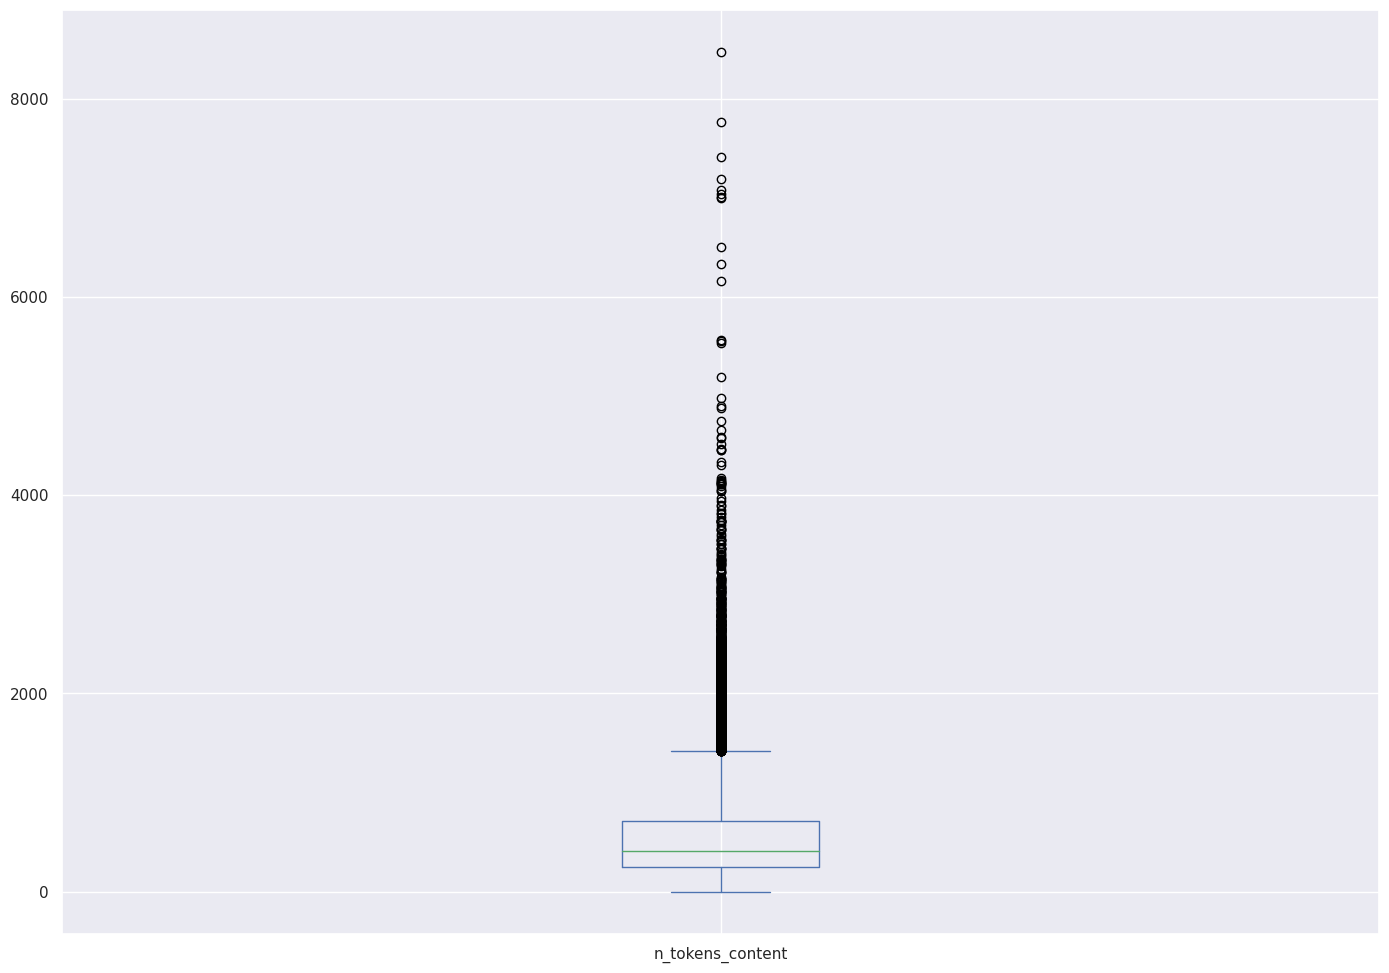

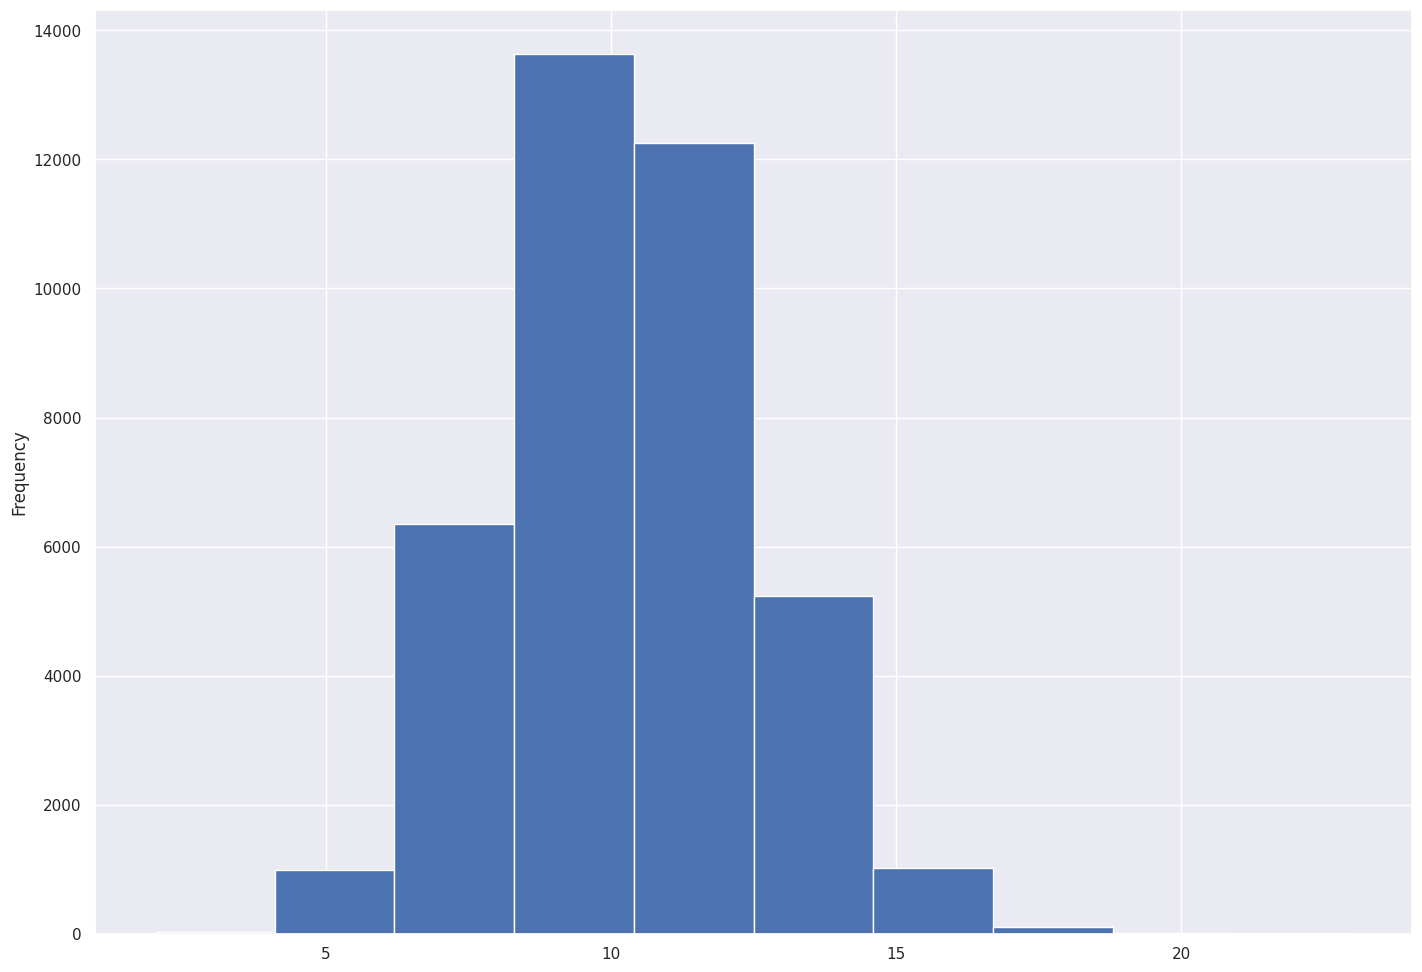

******************************************skew*************************************************
****************************************kurtosis***********************************************


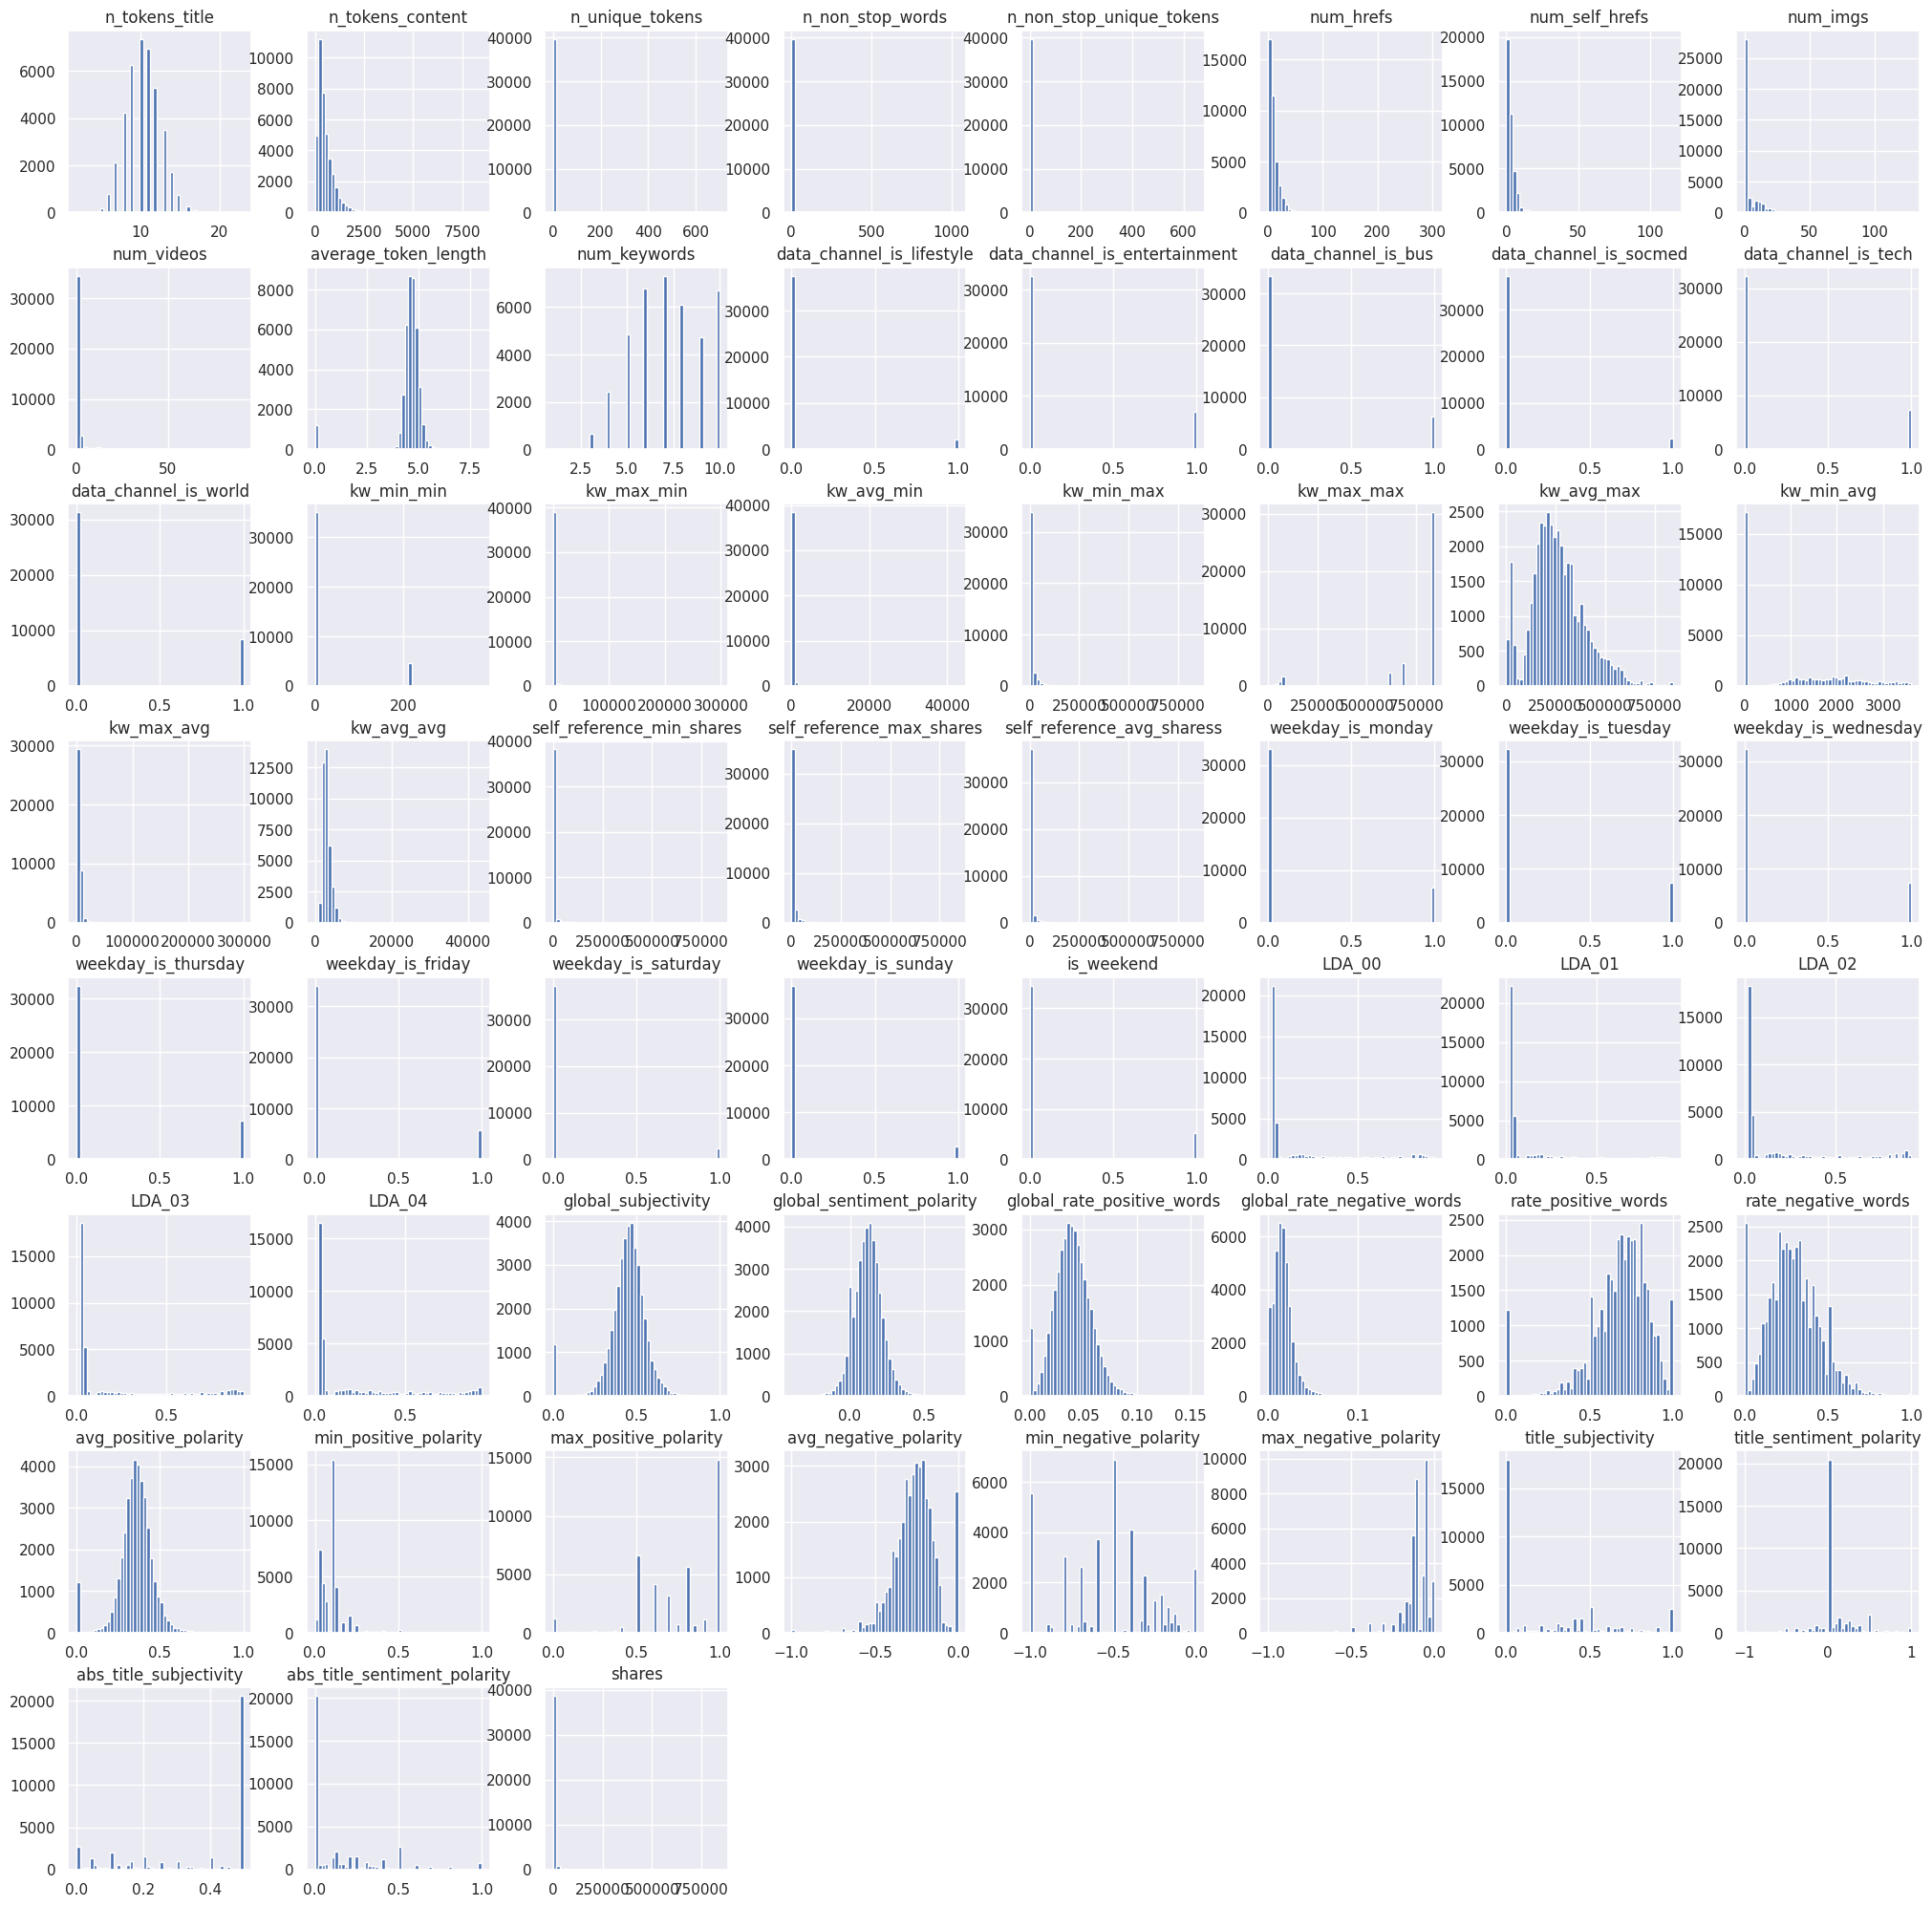

A couple of comments: Different scales, some features do not have the necessary values to see generate a histogram
for example week_is_monday altough is a numeric value, is a binary feature , but others like num_keywords have few categories
so the histogram is not possible to see a well-generated curve For a first model, we'll take into account the following numerical features:
n_tokens_content num_hrefs average_token_length kw_avg_max global_subjectivity , global_sentiment_polarity , global_rate_positive_words , global_rate_negative_words
rate_positive_words , rate_negative_words avg_positive_polarity , avg_negative_polarity Binary features: data_channel_is_lifestyle, data_channel_is_entertainment,
data_channel_is_bus, data_channel_is_socmed data_channel_is_tech, data_channel_is_world , weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday
Some transformations in order to make the skew different and distribution to have a centered curve
******************************************

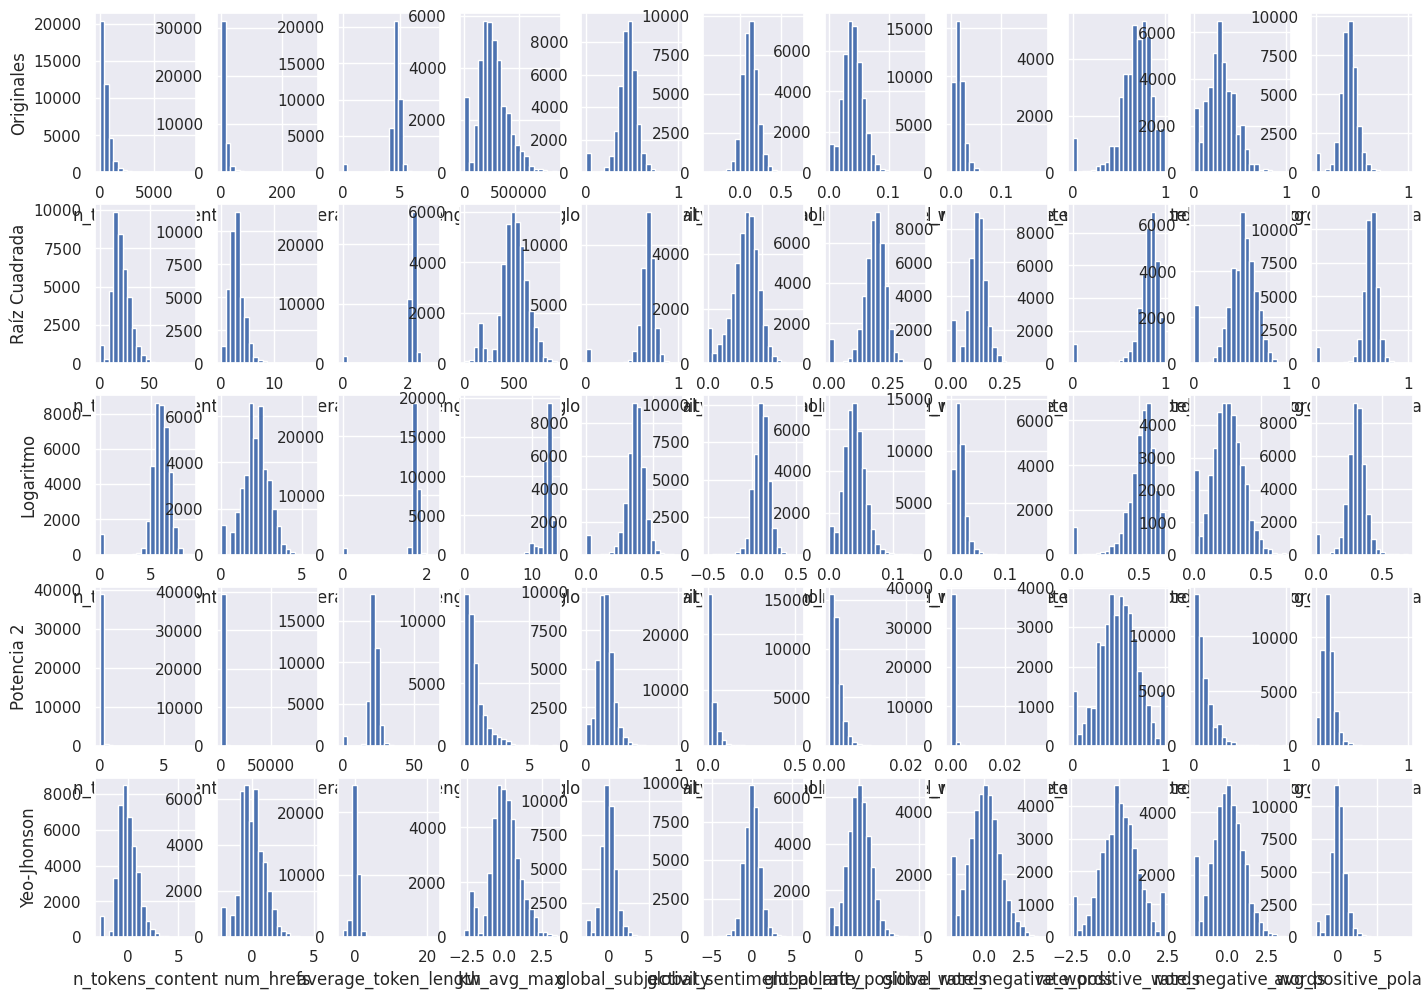

As the last column named avg_negative_polarity has a lot of negative values, if we apply operations such as square root, or log2 
We will get error, so the only option we have is to apply Yeo-Johnson, let's check if that can help


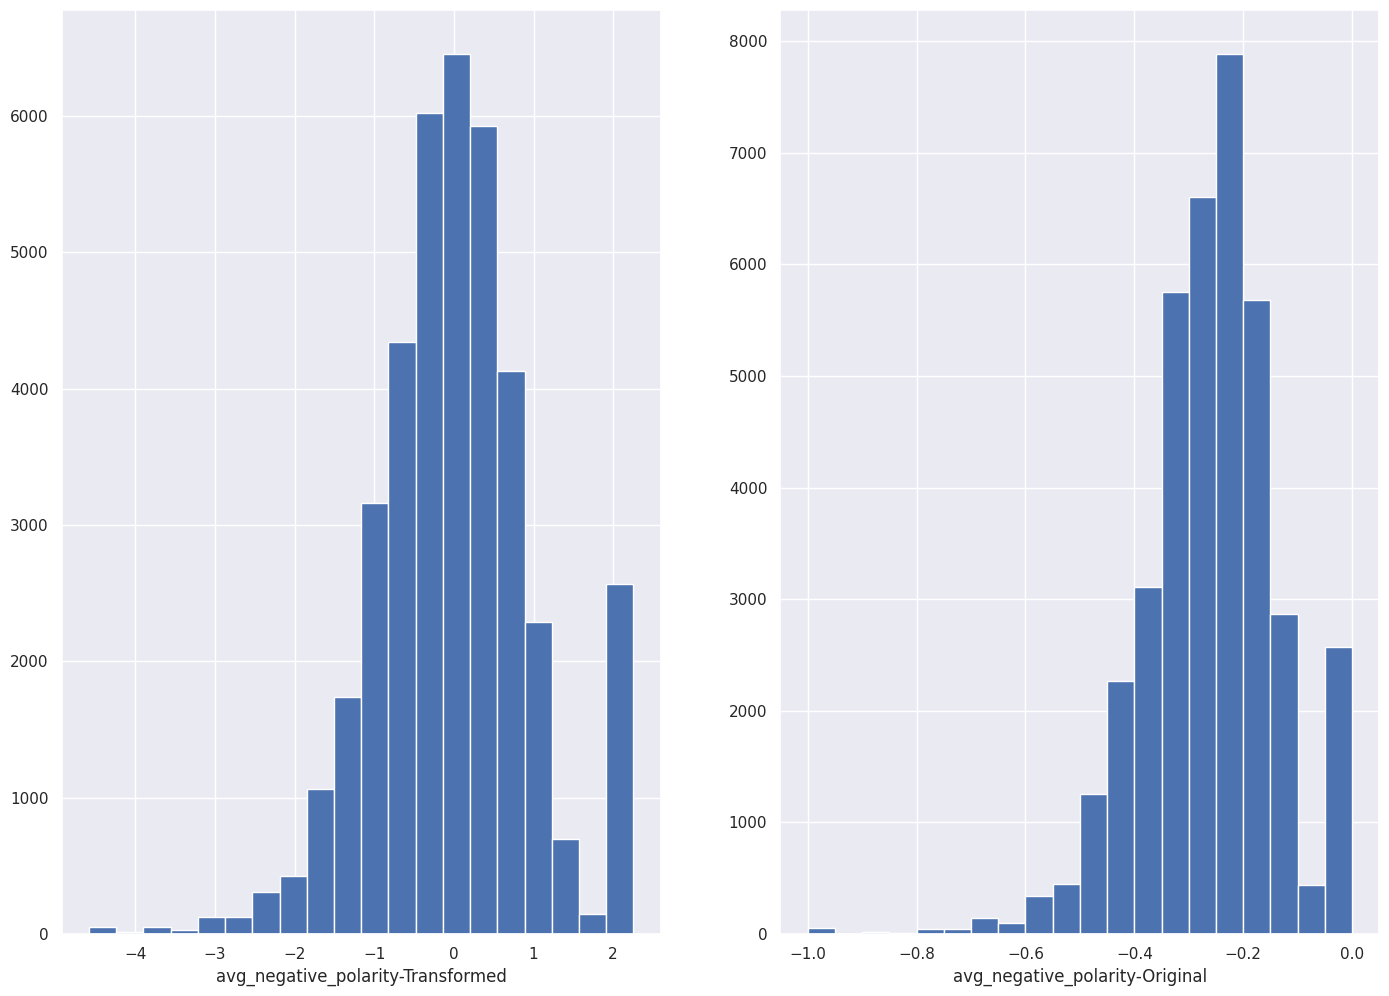

Puntos a destacar, podemos aplicar las siguientes transformaciones a las siguientes variables para corregir skew:
Númericas - Standard Scaler para que todos los rangos esten entre 0 y 1
num_hrefs - n_tokens_content -avg_positive_polarity - global_subjectivity - Logaritmo - np.log1p
average_token_length - global_sentiment_polarity - Original 
kw_avg_max - global_rate_positive_words- Raiz Cuadrada
global_rate_negative_words - rate_positive_words -rate_negative_words- Yeo Johnson 


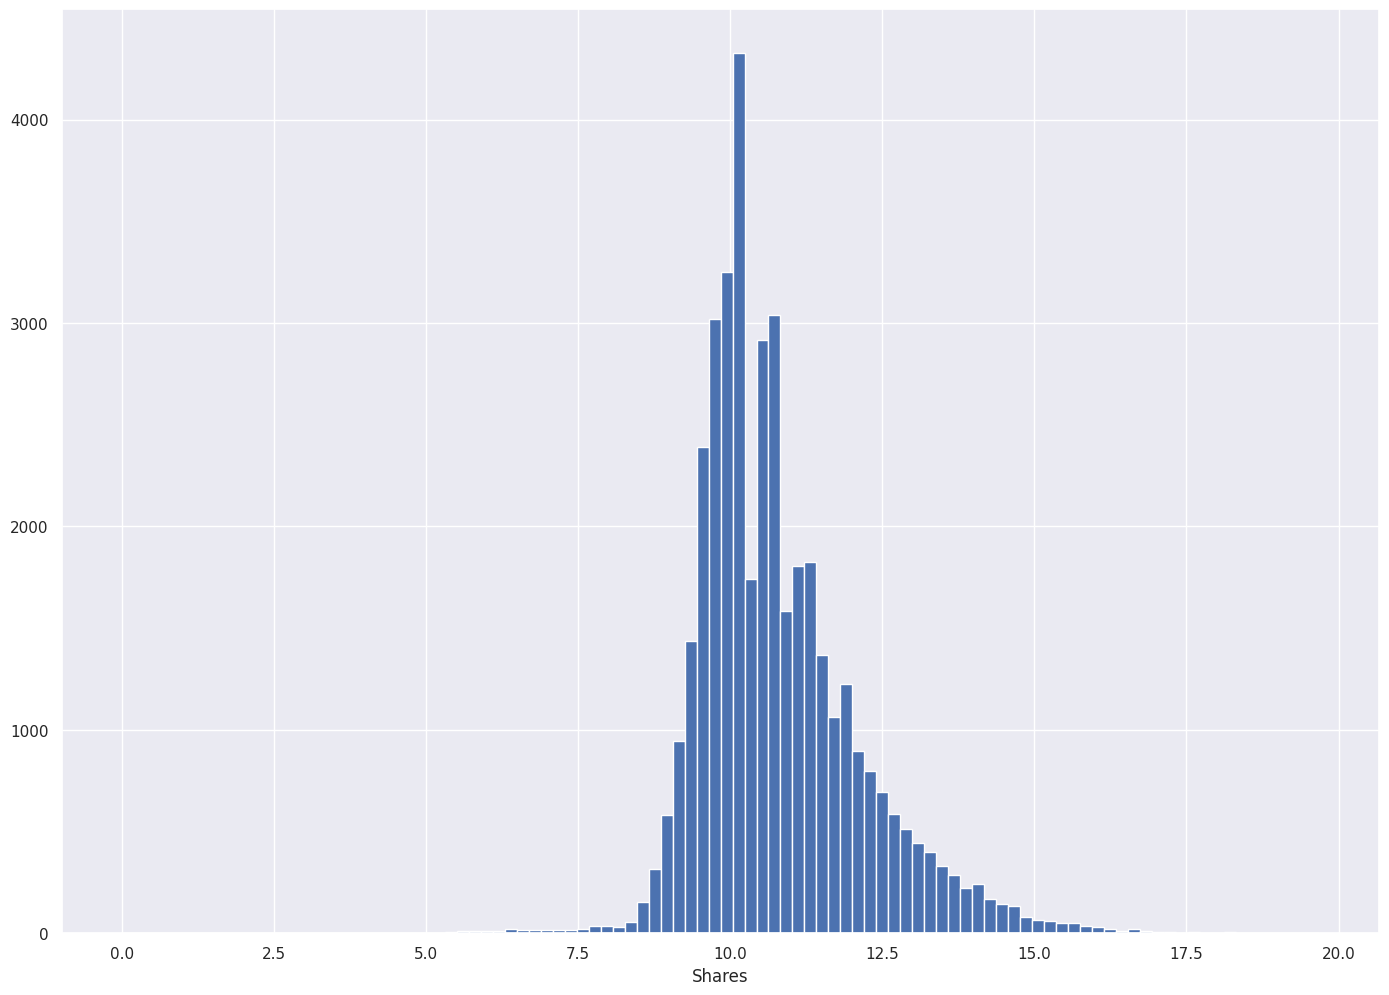

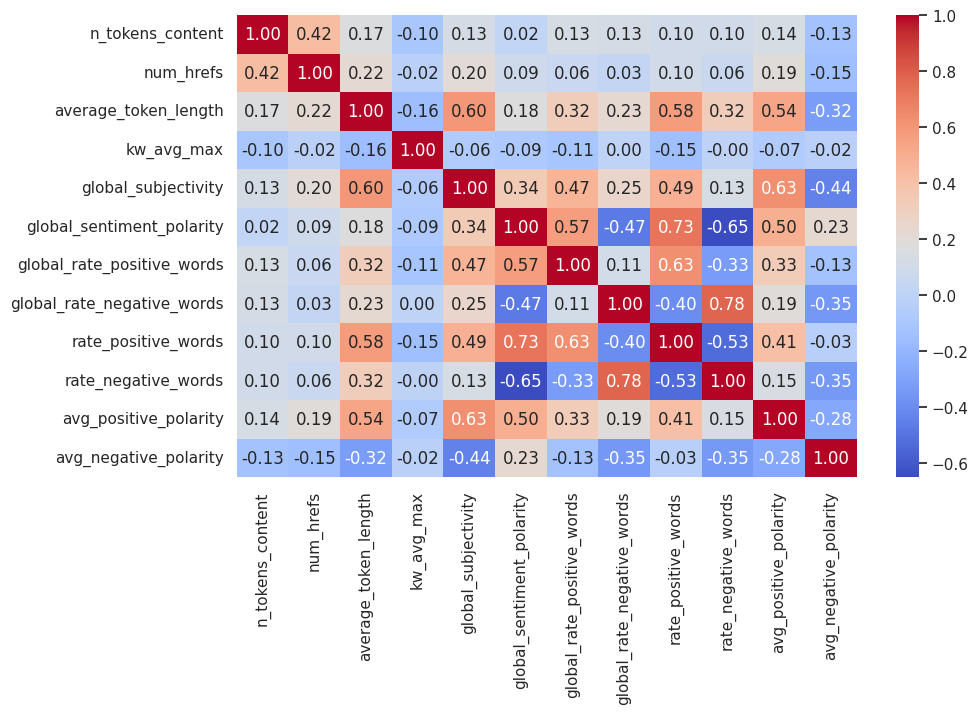

Error Cuadrático Medio: 1.4825105532379537


In [97]:
main()

-------------------------

Puntos a destacar, alta correlación entre:
   * n_tokens_content y num_hrefs
   * global_subjectivity y avg_positive_polarity
   * avg_positive_polarity y average_token_length
   * global_rate_positive_words y global_subjectivity